In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

### EDA
We download different datasets from different csv files to compare with Social Spending of GDP

In [5]:
drugs = pd.read_csv('../dataset/Bdata.csv')
gdp = pd.read_csv('../dataset/social-spending-oecd-longrun.csv')
alco = pd.read_csv('../dataset/rate-of-premature-deaths-due-to-alcohol.csv')
ineq = pd.read_csv('../dataset/inequality-before-and-after-taxes-and-transfers-Thewissen-et-al-data.csv')

In [36]:
# Merge two dataframe on years it matches and country name
# take years after 1977 which is the years where inequality dataset starts
gdp = gdp[gdp.Year >1977]
# Create new data set where we match the year of gdp to inequality of years
new = utils.nearestYear(gdp,ineq)
# Drop null values
new.dropna(inplace=True)
hone = pd.merge(ineq[['Entity','Year','Market Income','Disposable Income']], 
              new[['Entity','RoundYear','Social Expenditure %GDP - (OWID extrapolated series) (%)']],  
              how='inner', left_on=['Entity','Year'], right_on = ['Entity','RoundYear'])
# Rename Social Expediture percentage column
hone.rename(columns={'Social Expenditure %GDP - (OWID extrapolated series) (%)': 'Percent_GDP','Disposable Income':'Disposable_Income'},inplace=True)
# Delete row with  string '..' Convert object type to float
hone = hone[hone.Percent_GDP != '..']
hone.Percent_GDP = hone.Percent_GDP.astype(float)
hone = hone[hone.Percent_GDP != 0]
hone.dropna(inplace = True)
mean = hone.Percent_GDP.mean()
print('the average of percentage spend by countries is {}, the shape of the dataframe is {}'.format(mean,df.shape))
# Countries who spend more of their shares than mean percenteage percent
hone['MoreThanMean'] = hone.Percent_GDP.apply(lambda x: 0 if x < mean else 1)
# Gini index indicates if it is higher than there is higher inequality
print('The data starts from {} and ends in year {}'.format(hone.Year.min(),hone.Year.max()))
hone.head()

the average of percentage spend by countries is 19.21329161654386, the shape of the dataframe is (171, 7)
The data starts from 1978 and ends in year 2013


,Entity,Year,Market Income,Disposable_Income,RoundYear,Percent_GDP,MoreThanMean
0,Australia,1981,0.405,0.282,1981.0,10.637890,0
1,Australia,1985,0.440,0.293,1985.0,10.296414,0
2,Australia,1989,0.440,0.304,1989.0,10.268000,0
3,Australia,1995,0.483,0.311,1995.0,12.088000,0
4,Australia,2001,0.498,0.320,2001.0,13.131000,0


In [6]:
# i did all my clean 
drugs

,Entity,Year,Total government spending percapita (per capita USD PPP),Deaths,Over
0,Australia,2009,15670.840,1416.522917,False
1,Australia,2010,15484.240,1439.252130,False
2,Australia,2011,16146.340,1454.194877,True
3,Australia,2012,15628.890,1449.744176,False
4,Australia,2013,17186.980,1503.284879,True
...,...,...,...,...,...
298,United States,2011,20796.711,47700.832587,True
299,United States,2012,20560.391,51472.014917,True
300,United States,2013,20410.400,56252.462040,True
301,United States,2014,20741.029,62145.948617,True


### Hypothesis 1

- H0 = Government spending on its citizens does not have a effect on income equality?
- HA = Govenrment spending on its citizens decreases the income equality?

We have to check if our disposable income values are normally distributed so we run a QQ plot to see if it is normally distributed

Text(0.5, 1.0, 'Disposable Income Q-Q Plot')

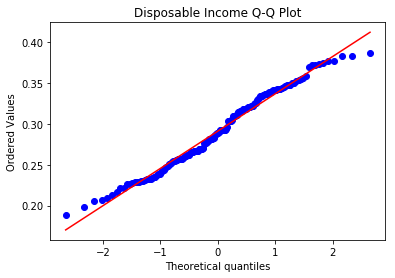

In [37]:
stats.probplot(hone['Disposable_Income'], plot= plt)
plt.title('Disposable Income Q-Q Plot')

After looking at Q-Q plot we can say that out distribution is normal enough. We are going to seperate the population in to two sample according to their spending of their GDP on its citizens. After that we are going to visualize two Datasets and see if there is a difference visible to the eye.

In [39]:
# Seperate the dataset to two different group with their characteristic
more_df = hone[hone.MoreThanMean == 1]
less_df = hone[hone.MoreThanMean == 0]

/Users/kaanbursa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


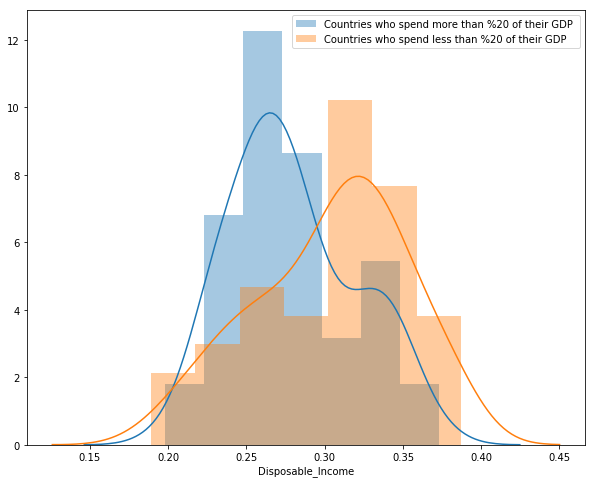

In [40]:
plt.figure(figsize=(10,8))
sns.distplot(more_df['Disposable_Income'],label='Countries who spend more than %20 of their GDP ')
sns.distplot(less_df['Disposable_Income'],label='Countries who spend less than %20 of their GDP')
plt.legend()

#### Statistical Analysis of Q1

In [41]:
from statsmodels.stats.power import TTestIndPower

In [42]:
# our alpha is 5%
alpha = 0.05
# Cohen's Distans is the difference between two population means which measures the effect size in T-test
cohend = abs(more_df['Disposable_Income'].mean() - less_df['Disposable_Income'].mean())
analysis = TTestIndPower()
power = analysis.solve_power(cohend, power=None, nobs1=len(more_df), ratio=1.0, alpha=alpha)
print("""Cohens distance for the populations is {} which is the effect size. Sample size is {}
and our significane level is (alpha) {} and our statistical power is {} 
      """.format(round(cohend,4),len(more_df),alpha,power))

Cohens distance for the populations is 0.0247 which is the effect size. Sample size is 88
and our significane level is (alpha) 0.05 and our statistical power is 0.05303715252335816 
      


We are going to run two tailed sided welchs-t-test so we can see if the effect is positive or negative
Negative t-value means higher the percentage share to people less income inequality and lower gini index

In [43]:
results = stats.ttest_ind(more_df['Disposable_Income'], less_df['Disposable_Income'],equal_var = False)

if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of {} is greater than mean of {}".format('Male','Female'))
else:
    print("accept null hypothesis with t-value of {} and p-value of {}".format(results[0],results[1]))

accept null hypothesis with t-value of -3.6422852388421982 and p-value of 0.00036488703355117637


### Notes on H1

- P-value : 0.0003648
- Statistical-Power : 0.05303

We wanted to compare two different sample's and wanted to see the effect if it was negative or positive. So we ran <strong>Welch's T-test </strong> since the sample populations where not identical. T-test gave us the result that the p-value is lower in our two sample's however when we did power analysis our our power parameter was really low meaning the we should not believe our alternative hypothesis easily with out sample size. 

So we fail to reject null hypothesis and need more data to conduct and answer to this question.

### Hypothesis 2



- H0 = Government spending on its citizens does not have any statistical significance effcect on Deaths from drug disorders?
- HA = Govenrment spending on its citizens has a statistical significance effcect on Deaths from drug disorders?

We have to check if our disposable income values are normally distributed so we run a QQ plot to see if it is normally distributed

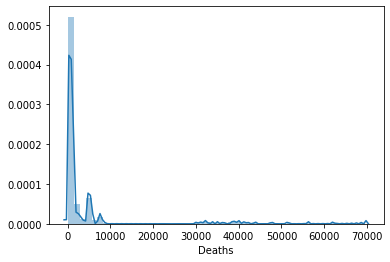

In [7]:
sns.distplot(drugs['Deaths']);

it is not. but to be sure i split the data into my null and alteritive hypotionions and check againe.

In [8]:
AT = drugs[drugs['Over']==True]
BT = drugs[drugs['Over']==False]

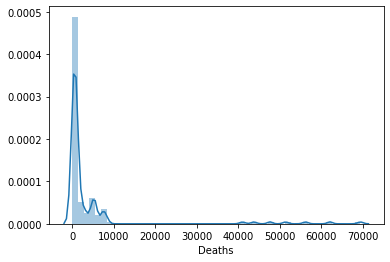

In [9]:
sns.distplot(AT['Deaths']);

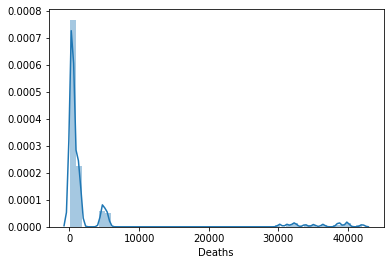

In [10]:
sns.distplot(BT['Deaths']);

it still not, therfor i will need to take sampling in order to get it into a normall diturbution.  

In [11]:
sample_means_A = []
for i in range(10**4):
    sample = AT.sample(n=50) #Take a sample of 50 people
    sample_means_A.append(sample.Deaths.mean()) #Calculate the sample mean

In [12]:
sample_means_B = []
for i in range(10**4):
    sample = BT.sample(n=50) #Take a sample of 50 people
    sample_means_B.append(sample.Deaths.mean()) #Calculate the sample mean

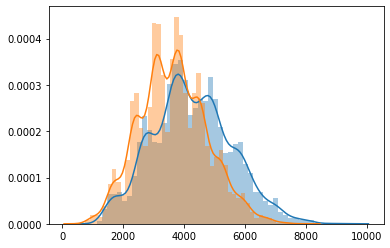

In [13]:
sns.distplot(sample_means_A)
sns.distplot(sample_means_B)

Clearly there is no saginificant 

# # Hypothesis 3

3. Q3: Does increasing the amount of government spending on its citizens decreases the deaths due to alcohol? 